<a href="https://colab.research.google.com/github/Sundragon1993/CS231n_2020/blob/main/Single_stage_detector_yolo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EECS 498-007/598-005 Assignment 5-1: Single-Stage Object Detector - YOLO

Before we start, please put your name and UMID in following format

: Firstname LASTNAME, #00000000   //   e.g.) Justin JOHNSON, #12345678

**Your Answer:**   
Dang Cong HOANG, #20081993

# Single-Stage Object Detector
In this exercise you will implement a **single-stage** object detector, based on YOLO ([v1](https://arxiv.org/pdf/1506.02640.pdf) and [v2](https://arxiv.org/pdf/1612.08242.pdf)) and use it to train a model that can detect objects on novel images. We will also evaluate the detection accuracy using the classic metric mean Average Precision ([mAP](https://github.com/Cartucho/mAP)). In Part II of A5, you will implement a **two-stage** object detector, based on [Faster R-CNN](https://arxiv.org/pdf/1506.01497.pdf). The main difference between the two is that single-stage detectors perform region proposal and classification simultaneously while two-stage detectors have them decoupled. 

# Getting Started

## Install starter code
We will continue using the utility functions that we've used for previous assignments: [`coutils` package](https://github.com/deepvision-class/starter-code). Run this cell to download and install it.


In [ ]:
!pip install git+https://github.com/deepvision-class/starter-code

  Cloning https://github.com/deepvision-class/starter-code to /tmp/pip-req-build-42nihi0r
  Running command git clone -q https://github.com/deepvision-class/starter-code /tmp/pip-req-build-42nihi0r
  Created wheel for Colab-Utils: filename=Colab_Utils-0.1.dev0-cp36-none-any.whl size=10324 sha256=64e29bf2c034ab53c40019dff283d51b7354139baa8d2e2920bc0d7138795d0c
  Stored in directory: /tmp/pip-ephem-wheel-cache-349e24tj/wheels/63/d1/27/a208931527abb98d326d00209f46c80c9d745851d6a1defd10
Successfully built Colab-Utils


## Setup code
Run some setup code for this notebook: Import some useful packages and increase the default figure size.

In [ ]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import coutils
from coutils import extract_drive_file_id, register_colab_notebooks, \
                    fix_random_seed, rel_error
import matplotlib.pyplot as plt
import numpy as np
import cv2
import copy
import time
import shutil
import os

# for plotting
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# data type and device for torch.tensor
to_float = {'dtype': torch.float, 'device': 'cpu'}
to_float_cuda = {'dtype': torch.float, 'device': 'cuda'}
to_double = {'dtype': torch.double, 'device': 'cpu'}
to_double_cuda = {'dtype': torch.double, 'device': 'cuda'}
to_long = {'dtype': torch.long, 'device': 'cpu'}
to_long_cuda = {'dtype': torch.long, 'device': 'cuda'}

# for mAP evaluation
!rm -rf mAP
!git clone https://github.com/Cartucho/mAP.git
!rm -rf mAP/input/*

Cloning into 'mAP'...
remote: Enumerating objects: 908, done.
remote: Total 908 (delta 0), reused 0 (delta 0), pack-reused 908
Receiving objects: 100% (908/908), 14.71 MiB | 43.04 MiB/s, done.
Resolving deltas: 100% (321/321), done.


We will use GPUs to accelerate our computation in this notebook. Run the following to make sure GPUs are enabled:

In [ ]:
if torch.cuda.is_available:
  print('Good to go!')
else:
  print('Please set GPU via Edit -> Notebook Settings.')

Good to go!


## Load PASCAL VOC 2007 data
During the majority of our homework assignments so far, we have used the CIFAR-10 dataset for image classification tasks.

We will need to use a new dataset for object detection. In order to train and evaluate object detection models, we need a dataset where each image is annotated with a *set* of *bounding boxes*, where each box gives the category label and spatial extent of some object in the image.

We will use the [PASCAL VOC 2007](http://host.robots.ox.ac.uk/pascal/VOC/) dataset, which provides annotations of this form. PASCAL VOC ran a series of yearly computer vision competitions from 2005 to 2012, predating the ImageNet challenge which we have discussed in class.

The data from the 2007 challenge used to be one of the most popular datasets for evaluating object detection. It is much smaller than more recent object detection datasets such as [COCO](http://cocodataset.org/#home), and thus easier to manage in an homework assignment.

The following function will download the PASCAL VOC 2007 dataset and return it as a PyTorch Dataset object:

In [ ]:
def get_pascal_voc2007_data(image_root, split='train'):
  """
  Use torchvision.datasets
  https://pytorch.org/docs/stable/torchvision/datasets.html#torchvision.datasets.VOCDetection
  """
  from torchvision import datasets

  train_dataset = datasets.VOCDetection(image_root, year='2007', image_set=split,
                                    download=True)
  
  return train_dataset

Run the following cell to download the training and validation sets for the PASCAL VOC 2007 dataset:

The [`Dataset`](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset) objects returned from the above function returns annotations for each image as a nested set of dictionary objects:

In [ ]:
# uncomment below to use the mirror link if the original link is broken
# !wget http://pjreddie.com/media/files/VOCtrainval_06-Nov-2007.tar
train_dataset = get_pascal_voc2007_data('/content', 'train')
val_dataset = get_pascal_voc2007_data('/content', 'val')

# an example on the raw annotation
import json
print(json.dumps(train_dataset[1][1]['annotation'], indent=2))

Using downloaded and verified file: /content/VOCtrainval_06-Nov-2007.tar
{
  "folder": "VOC2007",
  "filename": "000017.jpg",
  "source": {
    "database": "The VOC2007 Database",
    "annotation": "PASCAL VOC2007",
    "image": "flickr",
    "flickrid": "228217974"
  },
  "owner": {
    "flickrid": "genewolf",
    "name": "whiskey kitten"
  },
  "size": {
    "width": "480",
    "height": "364",
    "depth": "3"
  },
  "segmented": "0",
  "object": [
    {
      "name": "person",
      "pose": "Left",
      "truncated": "0",
      "difficult": "0",
      "bndbox": {
        "xmin": "185",
        "ymin": "62",
        "xmax": "279",
        "ymax": "199"
      }
    },
    {
      "name": "horse",
      "pose": "Left",
      "truncated": "0",
      "difficult": "0",
      "bndbox": {
        "xmin": "90",
        "ymin": "78",
        "xmax": "403",
        "ymax": "336"
      }
    }
  ]
}


In order to use these annotations to train our model, we need to convert this nested dictionary data structure into a set of PyTorch tensors.

We also need to preprocess the image, converting it to a PyTorch tensor and resizing it to 224x224. Real object detection systems typically work with much higher-resolution images, but we will use a low resolution for computational efficiency in this assignment.

We also want to train our models using minibatches of data, so we need to group the annotations from several images into minibatches.

We perform both of these functions by using a customized PyTorch [DataLoader](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) object, which we have written for you:

In [ ]:
def pascal_voc2007_loader(dataset, batch_size, num_workers=0):
  """
  Data loader for Pascal VOC 2007.
  https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader
  """
  from torch.utils.data import DataLoader
  # turn off shuffle so we can index the original image
  train_loader = DataLoader(dataset,
                            batch_size=batch_size,
                            shuffle=False, pin_memory=True,
                            num_workers=num_workers,
                            collate_fn=voc_collate_fn)
  return train_loader


class_to_idx = {'aeroplane':0, 'bicycle':1, 'bird':2, 'boat':3, 'bottle':4,
                'bus':5, 'car':6, 'cat':7, 'chair':8, 'cow':9, 'diningtable':10,
                'dog':11, 'horse':12, 'motorbike':13, 'person':14, 'pottedplant':15,
                'sheep':16, 'sofa':17, 'train':18, 'tvmonitor':19
}
idx_to_class = {i:c for c, i in class_to_idx.items()}


from torchvision import transforms

def voc_collate_fn(batch_lst, reshape_size=224):
    preprocess = transforms.Compose([
      transforms.Resize((reshape_size, reshape_size)),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
      ])
    
    batch_size = len(batch_lst)
    
    img_batch = torch.zeros(batch_size, 3, reshape_size, reshape_size)
    
    max_num_box = max(len(batch_lst[i][1]['annotation']['object']) \
                      for i in range(batch_size))

    box_batch = torch.Tensor(batch_size, max_num_box, 5).fill_(-1.)
    w_list = []
    h_list = []
    img_id_list = []
    
    for i in range(batch_size):
      img, ann = batch_lst[i]
      w_list.append(img.size[0]) # image width
      h_list.append(img.size[1]) # image height
      img_id_list.append(ann['annotation']['filename'])
      img_batch[i] = preprocess(img)
      all_bbox = ann['annotation']['object']
      if type(all_bbox) == dict: # inconsistency in the annotation file
        all_bbox = [all_bbox]
      for bbox_idx, one_bbox in enumerate(all_bbox):
        bbox = one_bbox['bndbox']
        obj_cls = one_bbox['name']
        box_batch[i][bbox_idx] = torch.Tensor([float(bbox['xmin']), float(bbox['ymin']),
          float(bbox['xmax']), float(bbox['ymax']), class_to_idx[obj_cls]])
    
    h_batch = torch.tensor(h_list)
    w_batch = torch.tensor(w_list)

    return img_batch, box_batch, w_batch, h_batch, img_id_list

Training with the entire PASCAL VOC will be too computationally expensive for this homework assignment, so we can subsample the dataset by wrapping each `Dataset` object in a [`Subset`](https://pytorch.org/docs/stable/data.html#torch.utils.data.Subset) object:

In [ ]:
train_dataset = torch.utils.data.Subset(train_dataset, torch.arange(0, 2500)) # use 2500 samples for training
train_loader = pascal_voc2007_loader(train_dataset, 10)
val_loader = pascal_voc2007_loader(val_dataset, 10)

The `DataLoader` objects return batches of data.

The first output from the `DataLoader` is a Tensor `img` of shape `(B, 3, 224, 224)`. This is a batch of `B` images, similar to what we have seen in classification datasets.

The second output from the `DataLoader` is a Tensor `ann` of shape `(B, N, 5)` giving information about all objects in all images of the batch. `ann[i, j] = (x_tl, y_tl, x_br, y_br, class)` gives information about the `j`th object in `img[i]`. The position of the top-left corner of the box is `(x_tl, y_tl)` and the position of the bottom-right corner of the box is `(x_br, y_br)`. These positions are in the coordinate system of the original image (before it was resized to 224 x 224). `class` is an integer giving the category label for this bounding box.

Each image can have different numbers of objects. If `img[i]` has $N_i$ objects, then $N=\max_i N_i$ is the maximum number of objects per image among all objects in the batch; this value can vary from batch to batch. For the images that have fewer than $N$ annotated objects, only the first $N_i$ rows of $anns[i]$ contain annotations; the remaining rows are padded with -1.

In [ ]:
train_loader_iter = iter(train_loader)
img, ann, _, _, _ = train_loader_iter.next()

print('img has shape: ', img.shape)
print('ann has shape: ', ann.shape)

print('Image 1 has only two annotated objects, so ann[1] is padded with -1:')
print(ann[1])

print('\nImage 2 has six annotated objects:, so ann[2] is not padded:')
print(ann[2])

print('\nEach row in the annotation tensor indicates (x_tl, y_tl, x_br, y_br, class).')

img has shape:  torch.Size([10, 3, 224, 224])
ann has shape:  torch.Size([10, 6, 5])
Image 1 has only two annotated objects, so ann[1] is padded with -1:
tensor([[185.,  62., 279., 199.,  14.],
        [ 90.,  78., 403., 336.,  12.],
        [ -1.,  -1.,  -1.,  -1.,  -1.],
        [ -1.,  -1.,  -1.,  -1.,  -1.],
        [ -1.,  -1.,  -1.,  -1.,  -1.],
        [ -1.,  -1.,  -1.,  -1.,  -1.]])

Image 2 has six annotated objects:, so ann[2] is not padded:
tensor([[  9., 230., 245., 500.,   1.],
        [230., 220., 334., 500.,   1.],
        [  2., 178.,  90., 500.,   1.],
        [  2.,   1., 117., 369.,  14.],
        [  3.,   2., 243., 462.,  14.],
        [225.,   1., 334., 486.,  14.]])

Each row in the annotation tensor indicates (x_tl, y_tl, x_br, y_br, class).


# Coordinate transformation
It's a good practice to use a consistent coordinate system for all the spatial-related computations (e.g., anchors, proposals). **In this assignment, we use the coordinate system defined by the CNN activation map (of shape 7x7), where the top-left corner is (0, 0) and the bottom-right corner is (7, 7). The horizontal axis is the x axis and the vertical axis is the y axis.**

The following function defines the transformation from the original image coordinate system (pixels, and the top-left corner is (0, 0)) to the activation map coordinate system and vice versa.

Notes: All the coordinates are in float precision. In later sections, we use the activation map coordinate system for all computations except for visualization.

In [ ]:
def coord_trans(bbox, w_pixel, h_pixel, w_amap=7, h_amap=7, mode='a2p'):
  """
  Coordinate transformation function. It converts the box coordinate from
  the image coordinate system to the activation map coordinate system and vice versa.
  In our case, the input image will have a few hundred of pixels in
  width/height while the activation map is of size 7x7.

  Input:
  - bbox: Could be either bbox, anchor, or proposal, of shape Bx*x4
  - w_pixel: Number of pixels in the width side of the original image, of shape B
  - h_pixel: Number of pixels in the height side of the original image, of shape B
  - w_amap: Number of pixels in the width side of the activation map, scalar
  - h_amap: Number of pixels in the height side of the activation map, scalar
  - mode: Whether transfer from the original image to activation map ('p2a') or
          the opposite ('a2p')

  Output:
  - resized_bbox: Resized box coordinates, of the same shape as the input bbox
  """

  assert mode in ('p2a', 'a2p'), 'invalid coordinate transformation mode!'
  assert bbox.shape[-1] >= 4, 'the transformation is applied to the first 4 values of dim -1'
  
  if bbox.shape[0] == 0: # corner cases
    return bbox

  resized_bbox = bbox.clone()
  # could still work if the first dim of bbox is not batch size
  # in that case, w_pixel and h_pixel will be scalars
  resized_bbox = resized_bbox.view(bbox.shape[0], -1, bbox.shape[-1])
  invalid_bbox_mask = (resized_bbox == -1) # indicating invalid bbox

  if mode == 'p2a':
    # pixel to activation
    width_ratio = w_pixel * 1. / w_amap
    height_ratio = h_pixel * 1. / h_amap
    resized_bbox[:, :, [0, 2]] /= width_ratio.view(-1, 1, 1)
    resized_bbox[:, :, [1, 3]] /= height_ratio.view(-1, 1, 1)
  else:
    # activation to pixel
    width_ratio = w_pixel * 1. / w_amap
    height_ratio = h_pixel * 1. / h_amap
    print("Debug w_pixel and h_pixel:",w_pixel,h_pixel)
    resized_bbox[:, :, [0, 2]] *= width_ratio.view(-1, 1, 1) #[0,2] x_tl,x_br
    resized_bbox[:, :, [1, 3]] *= height_ratio.view(-1, 1, 1)#[1,3] y_tl,y_br

  resized_bbox.masked_fill_(invalid_bbox_mask, -1)
  resized_bbox.resize_as_(bbox)
  return resized_bbox

# Data Visualizer
This function will help us visualize boxes on top of images.

In [ ]:
def data_visualizer(img, idx_to_class, bbox=None, pred=None):
  """
  Data visualizer on the original image. Support both GT box input and proposal input.
  
  Input:
  - img: PIL Image input
  - idx_to_class: Mapping from the index (0-19) to the class name
  - bbox: GT bbox (in red, optional), a tensor of shape Nx5, where N is
          the number of GT boxes, 5 indicates (x_tl, y_tl, x_br, y_br, class)
  - pred: Predicted bbox (in green, optional), a tensor of shape N'x6, where
          N' is the number of predicted boxes, 6 indicates
          (x_tl, y_tl, x_br, y_br, class, object confidence score)
  """

  img_copy = np.array(img).astype('uint8')

  if bbox is not None:
    for bbox_idx in range(bbox.shape[0]):
      one_bbox = bbox[bbox_idx][:4]
      cv2.rectangle(img_copy, (one_bbox[0], one_bbox[1]), (one_bbox[2],
                  one_bbox[3]), (255, 0, 0), 2)
      if bbox.shape[1] > 4: # if class info provided
        obj_cls = idx_to_class[bbox[bbox_idx][4].item()]
        cv2.putText(img_copy, '%s' % (obj_cls),
                  (one_bbox[0], one_bbox[1]+15),
                  cv2.FONT_HERSHEY_PLAIN, 1.0, (0, 0, 255), thickness=1)

  if pred is not None:
    for bbox_idx in range(pred.shape[0]):
      one_bbox = pred[bbox_idx][:4]
      cv2.rectangle(img_copy, (one_bbox[0], one_bbox[1]), (one_bbox[2],
                  one_bbox[3]), (0, 255, 0), 2)
      
      if pred.shape[1] > 4: # if class and conf score info provided
        obj_cls = idx_to_class[pred[bbox_idx][4].item()]
        conf_score = pred[bbox_idx][5].item()
        cv2.putText(img_copy, '%s, %.2f' % (obj_cls, conf_score),
                    (one_bbox[0], one_bbox[1]+15),
                    cv2.FONT_HERSHEY_PLAIN, 1.0, (0, 0, 255), thickness=1)

  plt.imshow(img_copy)
  plt.axis('off')
  plt.show()

## Visualize PASCAL VOC 2007
It is always good practice to try and visualize parts of your dataset before you build a model.

Here we sample some  images from the PASCAL VOC 2007 training set, and visualize the ground-truth object boxes and category labels:

In [ ]:
# default examples for visualization
fix_random_seed(0)
batch_size = 3
sampled_idx = torch.linspace(0, len(train_dataset)-1, steps=batch_size).long()
print("length of sampled_idx",len(sampled_idx), sampled_idx)
print("length of train_dataset",len(train_dataset))

# get the size of each image first
h_list = []
w_list = []
img_list = [] # list of images
MAX_NUM_BBOX = 40
box_list = torch.LongTensor(batch_size, MAX_NUM_BBOX, 5).fill_(-1) # PADDED GT boxes

for idx, i in enumerate(sampled_idx):
  # hack to get the original image so we don't have to load from local again...
  img, ann = train_dataset.__getitem__(i)
  img_list.append(img)

  all_bbox = ann['annotation']['object']
  # print("all bboxes: ", all_bbox)
  if type(all_bbox) == dict:
    all_bbox = [all_bbox]
  for bbox_idx, one_bbox in enumerate(all_bbox):
    bbox = one_bbox['bndbox']
    obj_cls = one_bbox['name']
    box_list[idx][bbox_idx] = torch.LongTensor([int(bbox['xmin']), int(bbox['ymin']),
      int(bbox['xmax']), int(bbox['ymax']), class_to_idx[obj_cls]])
    print("idx: ",idx,"bbox_idx:",bbox_idx)
    print("box_list: ",box_list[idx][bbox_idx])
    

  # get sizes
  img = np.array(img)
  w_list.append(img.shape[1])
  h_list.append(img.shape[0])

w_list = torch.as_tensor(w_list, **to_float_cuda)
h_list = torch.as_tensor(h_list, **to_float_cuda)
box_list = torch.as_tensor(box_list, **to_float_cuda)
resized_box_list = coord_trans(box_list, w_list, h_list, mode='p2a') # on activation map coordinate system

length of sampled_idx 3 tensor([   0, 1249, 2499])
length of train_dataset 2500
idx:  0 bbox_idx: 0
box_list:  tensor([156,  97, 351, 270,   6])
idx:  1 bbox_idx: 0
box_list:  tensor([ 97,  16, 382, 291,   7])
idx:  1 bbox_idx: 1
box_list:  tensor([  1, 225, 441, 373,  19])
idx:  2 bbox_idx: 0
box_list:  tensor([192, 142, 330, 187,   6])


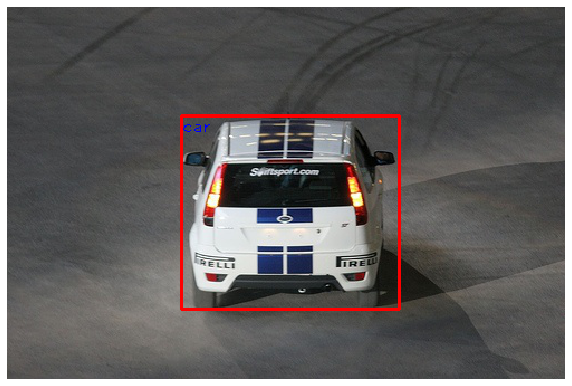

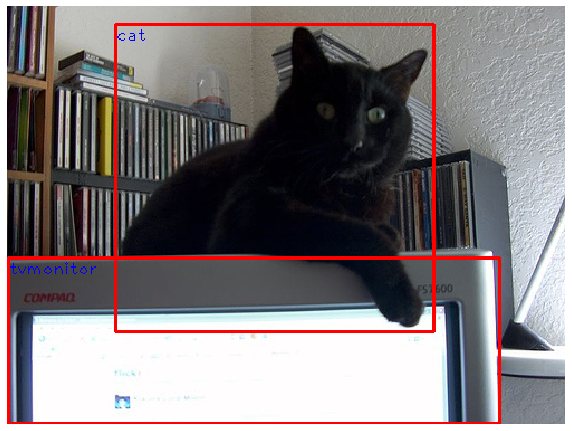

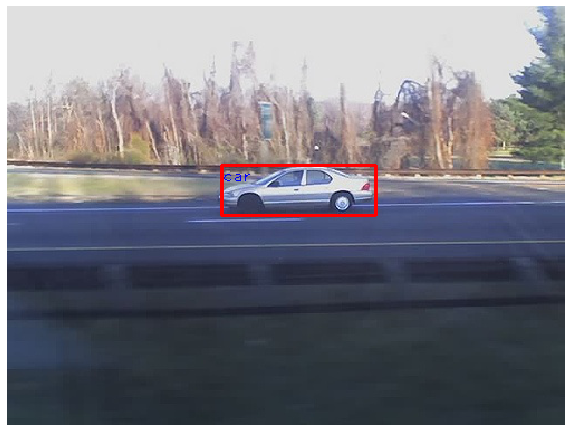

In [ ]:
# visualize GT boxes
for i in range(len(img_list)):
  valid_box = sum([1 if j != -1 else 0 for j in box_list[i][:, 0]])
  data_visualizer(img_list[i], idx_to_class, box_list[i][:valid_box])

# Detector Backbone Network
Here, we use [MobileNet v2](https://pytorch.org/hub/pytorch_vision_mobilenet_v2/) for image feature extraction. The code is based on Assignment 4-2.

In [ ]:
class FeatureExtractor(nn.Module):
  """
  Image feature extraction with MobileNet.
  """
  def __init__(self, reshape_size=224, pooling=False, verbose=False):
    super().__init__()

    from torchvision import models
    from torchsummary import summary

    self.mobilenet = models.mobilenet_v2(pretrained=True)
    self.mobilenet = nn.Sequential(*list(self.mobilenet.children())[:-1]) # Remove the last classifier

    # average pooling
    if pooling:
      self.mobilenet.add_module('LastAvgPool', nn.AvgPool2d(math.ceil(reshape_size/32.))) # input: N x 1280 x 7 x 7

    for i in self.mobilenet.named_parameters():
      i[1].requires_grad = True # fine-tune all

    if verbose:
      summary(self.mobilenet.cuda(), (3, reshape_size, reshape_size))
  
  def forward(self, img, verbose=False):
    """
    Inputs:
    - img: Batch of resized images, of shape Nx3x224x224
    
    Outputs:
    - feat: Image feature, of shape Nx1280 (pooled) or Nx1280x7x7
    """
    num_img = img.shape[0]
    
    img_prepro = img

    feat = []
    process_batch = 500
    for b in range(math.ceil(num_img/process_batch)):
      feat.append(self.mobilenet(img_prepro[b*process_batch:(b+1)*process_batch]
                              ).squeeze(-1).squeeze(-1)) # forward and squeeze
    feat = torch.cat(feat)
    
    if verbose:
      print('Output feature shape: ', feat.shape)
    
    return feat

Now, let's see what's inside MobileNet v2. Assume we have a 3x224x224 image input.

In [ ]:
model = FeatureExtractor(verbose=True)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth



----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
             ReLU6-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
             ReLU6-6         [-1, 32, 112, 112]               0
            Conv2d-7         [-1, 16, 112, 112]             512
       BatchNorm2d-8         [-1, 16, 112, 112]              32
  InvertedResidual-9         [-1, 16, 112, 112]               0
           Conv2d-10         [-1, 96, 112, 112]           1,536
      BatchNorm2d-11         [-1, 96, 112, 112]             192
            ReLU6-12         [-1, 96, 112, 112]               0
           Conv2d-13           [-1, 96, 56, 56]             864
      BatchNorm2d-14           [-1, 96

# Anchor and Proposal
The concept of *anchor* is introduced in [Faster R-CNN](https://arxiv.org/pdf/1506.01497.pdf) and later used in numerous later works including [YOLO v2](https://arxiv.org/pdf/1612.08242.pdf). The definition of anchor from the original paper is summarized as follows:

After passing the input image through the backbone network, we have a convolutional feature map of shape $(C, 7, 7)$ which we interpret as a 7x7 grid of $C$-dimensional features. At each point in this grid, we consider a set of $A$ *anchor boxes* of different sizes and shapes; for each anchor box we classify it as either an object or background box. The total number of anchor boxes that we consider for the entire input image is $(A, 7, 7)$; we predict classification scores of this shape by applying a sequence of convolutional layers to the backbone features.

We slide a small network (e.g., 3x3 conv layer) over the CNN activation feature map. We call this 3x3 conv a sliding window. At each sliding-window location (i.e., centered at each position of the 7x7 activation cell), we simultaneously predict multiple region *proposals*, where the number of proposals for each location is denoted as $A=9$.

Later, we will have an object proposal layer outputs
A-D scores that estimate probability of object for each proposal, a bounding box regression layer to produce 4A-D outputs encoding
the coordinates of A boxes, and a region classification layer to produce 20-D outputs indicating the probability of being each object category (shared by all A anchors). The A *proposals* are parameterized relative to A reference boxes, which we call *anchors*. An anchor is centered at the sliding window in question, and is associated with a shape (e.g., 1x1, 3x3, 5x5). The list of anchor shapes are provided next.






## Anchor shapes
At each spatial position of the 7x7 backbone features, we consider a set of $A$ anchor boxes. Different spatial positions all use anchors of the same shape.

The shapes of the anchor boxes are a hyperparameter. We will provide the anchor shapes for you, and we will re-use the same anchor shapes for both A5-1 and A5-2. In some papers (e.g. YOLO v2), the anchor shapes are determined in a data-driven way by clustering the set of ground-truth box sizes, but for simplicity we will not use that approach in this assignment.

Note that anchors could be much larger than the 3x3 sliding window (e.g., 5x5) since the receptive field of activation cell on the original image could be large.

In [ ]:
# Declare variables for anchor priors, a Ax2 Tensor where A is the number of anchors.
# Hand-picked, same as our two-stage detector.
anchor_list = torch.tensor([[1, 1], [2, 2], [3, 3], [4, 4], [5, 5], [2, 3], [3, 2], [3, 5], [5, 3]], **to_float_cuda)
print(anchor_list.shape)
print(len(anchor_list))

torch.Size([9, 2])
9


## Activation Grid Generator
In order to place anchors centered at each position of the 7x7 grid of backbone features, we need to know the spatial position of the center of each cell in the 7x7 grid of features.

This function will compute these center coordinates for us.

In [ ]:
def GenerateGrid(batch_size, w_amap=7, h_amap=7, dtype=torch.float32, device='cuda'):
  """
  Return a grid cell given a batch size (center coordinates).

  Inputs:
  - batch_size, B
  - w_amap: or W', width of the activation map (number of grids in the horizontal dimension)
  - h_amap: or H', height of the activation map (number of grids in the vertical dimension)
  - W' and H' are always 7 in our case while w and h might vary.
  
  Outputs:
  grid: A float32 tensor of shape (B, H', W', 2) giving the (x, y) coordinates
        of the centers of each feature for a feature map of shape (B, D, H', W')
  """
  w_range = torch.arange(0, w_amap, dtype=dtype, device=device) + 0.5
  h_range = torch.arange(0, h_amap, dtype=dtype, device=device) + 0.5

  w_grid_idx = w_range.unsqueeze(0).repeat(h_amap, 1)
  h_grid_idx = h_range.unsqueeze(1).repeat(1, w_amap)
  grid = torch.stack([w_grid_idx, h_grid_idx], dim=-1)
  grid = grid.unsqueeze(0).repeat(batch_size, 1, 1, 1)

  return grid


grid_list giving the (x, y) coordinates of the centers of each feature for a feature map: torch.Size([3, 7, 7, 2])
Debug w_pixel and h_pixel: tensor([500., 500., 500.], device='cuda:0') tensor([333., 374., 375.], device='cuda:0')
Debug w_pixel and h_pixel: tensor([500., 500., 500.], device='cuda:0') tensor([333., 374., 375.], device='cuda:0')


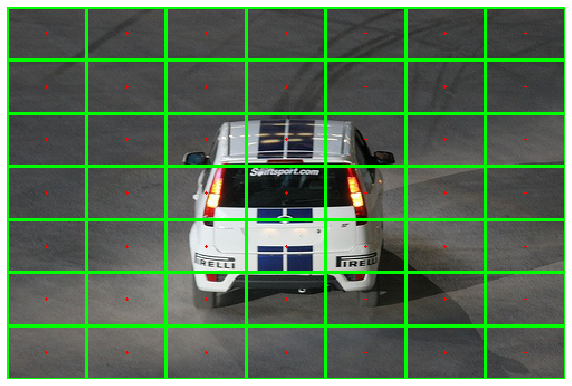

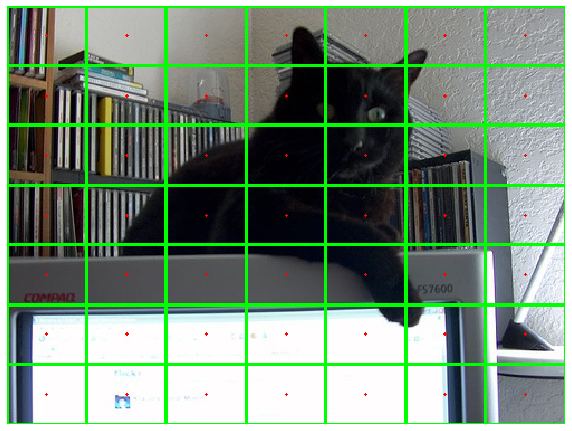

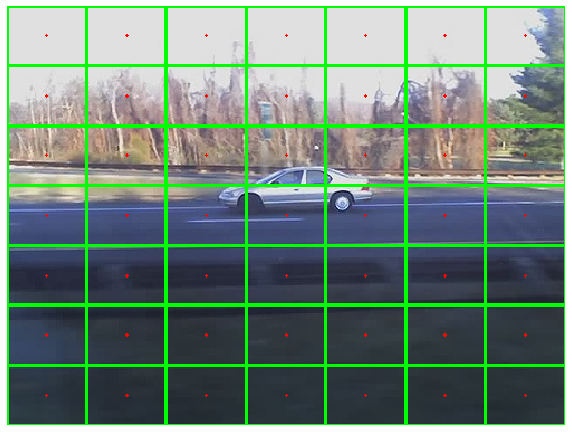

In [ ]:
# visualization
# simply create an activation grid where the cells are in green and the centers in red
# you should see the entire image divided by a 7x7 grid, with no gaps on the edges

grid_list = GenerateGrid(w_list.shape[0])
print("grid_list giving the (x, y) coordinates of the centers of each feature for a feature map:",grid_list.shape)
center = torch.cat((grid_list, grid_list), dim=-1)
# print("Centers are:", grid_list)
grid_cell = center.clone()
grid_cell[:, :, :, [0, 1]] -= 1. / 2.
grid_cell[:, :, :, [2, 3]] += 1. / 2.
center = coord_trans(center, w_list, h_list)
grid_cell = coord_trans(grid_cell, w_list, h_list)

for img, anc, grid in zip(img_list, center, grid_cell):
  data_visualizer(img, idx_to_class, anc.reshape(-1, 4), grid.reshape(-1, 4))

## Anchor Generator
At this point we have defined the spatial sizes of anchors that we consider at each grid point, and we have computed the center of each grid point. We now combine these two pieces of information to compute the positions of all anchor boxes for the entire image.


We denote the anchor coordinates as ($x_{tl}^a$, $y_{tl}^a$, $x_{br}^a$, $y_{br}^a$), indicating the coordinates of the top-left corner and the bottom-right corner accordingly. The following function returns all the anchors given the anchor shapes and the grid cell. **Note that the center of an anchor overlaps a grid cell center.**

In [ ]:
def GenerateAnchor(anc, grid):
  """
  Anchor generator.

  Inputs:
  - anc: Tensor of shape (A, 2) giving the shapes of anchor boxes to consider at
    each point in the grid. anc[a] = (w, h) gives the width and height of the
    a'th anchor shape.
  - grid: Tensor of shape (B, H', W', 2) giving the (x, y) coordinates of the
    center of each feature from the backbone feature map. This is the tensor
    returned from GenerateGrid.
  
  Outputs:
  - anchors: Tensor of shape (B, A, H', W', 4) giving the positions of all
    anchor boxes for the entire image. anchors[b, a, h, w] is an anchor box
    centered at grid[b, h, w], whose shape is given by anc[a]; we parameterize
    boxes as anchors[b, a, h, w] = (x_tl, y_tl, x_br, y_br), where (x_tl, y_tl)
    and (x_br, y_br) give the xy coordinates of the top-left and bottom-right
    corners of the box.
  """
  anchors = None
  ##############################################################################
  # TODO: Given a set of anchor shapes and a grid cell on the activation map,  #
  # generate all the anchor coordinates for each image. Support batch input.   #
  ##############################################################################
  # Replace "pass" statement with your code
  A = len(anc)
  B,H_,W_,_ = grid.shape
  anchors = torch.zeros((B,A,H_,W_,4),dtype=grid.dtype,device=grid.device).fill_(-1)
  for b in range(B):
    for a in range(A):
      w_anchor, h_anchor = anc[a]
      for w in range(W_):
        for h in range(H_):
          center_x, center_y = grid[b,h,w]
          x_tl = center_x-w_anchor/2
          y_tl = center_y-h_anchor/2
          x_br = center_x+w_anchor/2
          y_br = center_y+h_anchor/2
          anchors[b,a,h,w] = torch.tensor((x_tl, y_tl, x_br, y_br))
  ##############################################################################
  #                               END OF YOUR CODE                             #
  ##############################################################################

  return anchors

Run the following to check your implementation. You should see errors on the order of 1e-8 or less.

In [ ]:
# sanity check
anc_list = GenerateAnchor(anchor_list, grid_list)
assert anc_list.shape == torch.Size([3, 9, 7, 7, 4]), 'shape mismatch!'

expected_anc_list_mean = torch.tensor([[-1.25000000, -0.87500000,  2.25000000,  1.87500000],
                                       [ 1.75000000, -0.87500000,  5.25000000,  1.87500000],
                                       [ 4.75000000, -0.87500000,  8.25000000,  1.87500000],
                                       [-1.25000000,  1.12500000,  2.25000000,  3.87500000],
                                       [ 1.75000000,  1.12500000,  5.25000000,  3.87500000],
                                       [ 4.75000000,  1.12500000,  8.25000000,  3.87500000],
                                       [-1.25000000,  3.12500000,  2.25000000,  5.87500000],
                                       [ 1.75000000,  3.12500000,  5.25000000,  5.87500000],
                                       [ 4.75000000,  3.12500000,  8.25000000,  5.87500000],
                                       [-1.25000000,  5.12500000,  2.25000000,  7.87500000],
                                       [ 1.75000000,  5.12500000,  5.25000000,  7.87500000],
                                       [ 4.75000000,  5.12500000,  8.25000000,  7.87500000]], **to_float_cuda)
print('rel error: ', rel_error(expected_anc_list_mean, anc_list[0, [1,3,6,8], ::2, ::3, :].view(-1, 12, 4).mean(0)))

rel error:  0.0


********************************************************************************
All nine anchors should be exactly centered:
tensor([[[[3.5000, 3.5000]]],


        [[[3.5000, 3.5000]]],


        [[[3.5000, 3.5000]]]], device='cuda:0')
Debug w_pixel and h_pixel: tensor([500., 500., 500.], device='cuda:0') tensor([333., 374., 375.], device='cuda:0')
torch.Size([9, 1, 1, 4])


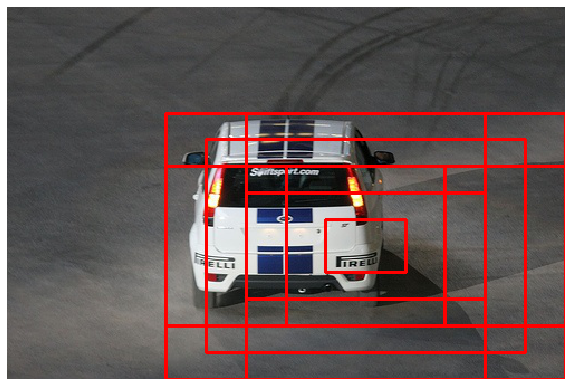

torch.Size([9, 1, 1, 4])


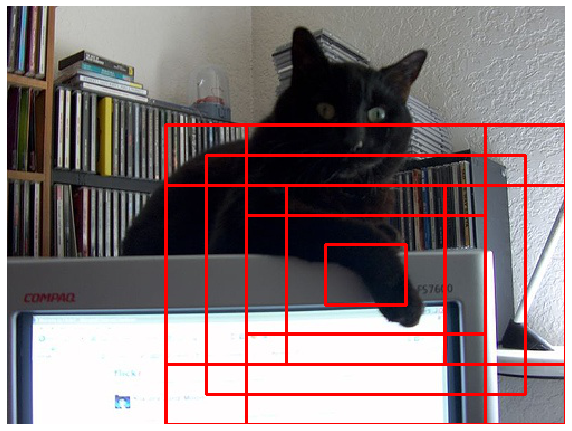

torch.Size([9, 1, 1, 4])


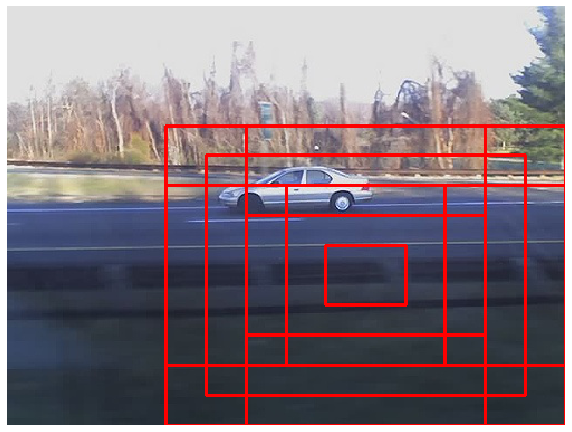

********************************************************************************
All anchors of the image (cluttered):
Debug w_pixel and h_pixel: tensor([500., 500., 500.], device='cuda:0') tensor([333., 374., 375.], device='cuda:0')
torch.Size([9, 7, 7, 4])


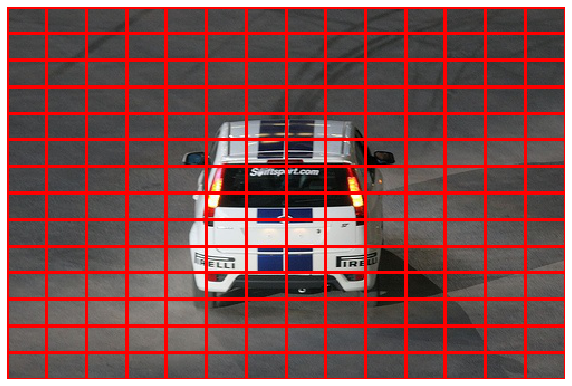

torch.Size([9, 7, 7, 4])


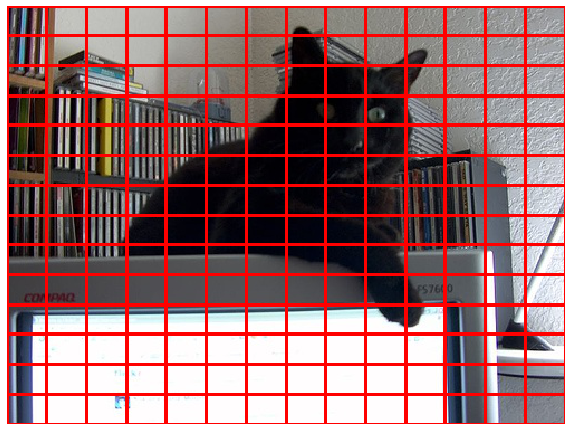

torch.Size([9, 7, 7, 4])


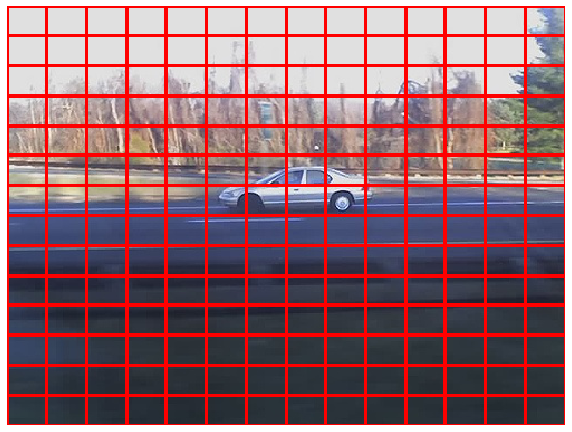

In [ ]:
# visualization
print('*'*80)
print('All nine anchors should be exactly centered:')
print(grid_list[:,3:4,3:4])
anc_list = GenerateAnchor(anchor_list, grid_list[:, 4:5, 4:5])
for img, anc in zip(img_list, coord_trans(anc_list, w_list, h_list)):
  print(anc.shape)
  data_visualizer(img, idx_to_class, anc.reshape(-1, 4))

print('*'*80)
print('All anchors of the image (cluttered):')
anc_list = GenerateAnchor(anchor_list, grid_list) # all
for img, anc in zip(img_list, coord_trans(anc_list, w_list, h_list)):
  print(anc.shape)
  data_visualizer(img, idx_to_class, anc.reshape(-1, 4))

## Proposal Generator
If we only use anchors to propose object locations, we can only cover 9x7x7=441 regions in the image. What if an object does not fall into any of the regions?

Hence, in the recent literatures (e.g., [Fast R-CNN](https://arxiv.org/pdf/1504.08083.pdf)), the detector predicts transformations that convert anchor boxes into *region proposals*.

So far, we have represented anchors boxes by the coordinates of their top-left and bottom-right corners $(x_{tl}^a, y_{tl}^a, x_{br}^a, y_{br}^a)$. When converting anchors to proposals, it will be more convenient to parameterize boxes by the xy coordinate of their center, and their with and height: $(x_c^a,y_c^a,w^a,h^a)$.

Now, consider an anchor box with center, width and height $(x_c^a,y_c^a,w^a,h^a)$.
The network will predict a *transformation* $(t^x, t^y, t^w, t^h)$; applying this transformation to the anchor yields a *region proposal* with center, width and height $(x_c^p,y_c^p,w^p,h^p)$.
YOLO and Faster R-CNN use slightly different formulas to convert anchors into proposals. Here you need to implement both formulations.

### YOLO
For YOLO, we assume that $t^x$ and $t^y$ are both in the range $-0.5\leq t^x,t^y\leq 0.5$, while $t^w$ and $t^h$ are real numbers in the range $(-\infty, \infty)$. Then we have:
- $x_c^p = x_c^a + t^x$
- $y_c^p = y_c^a + t^y$
- $w^p = w_a exp(t^w)$
- $h^p = h_a exp(t^h)$

### Faster R-CNN
For Faster R-CNN, we assume that all transformation parameters $t^x, t^y, t^w, t_h$ are real numbers in the range $(-\infty, \infty)$. Then we have:
- $x_c^p = x_c^a + t^xw^a$
- $y_c^p = y_c^p + t^yh^a$
- $w^p = w_a exp(t^w)$
- $h^p = h_a exp(t^h)$


### Training
During training, we compute the ground-truth transformation $(\hat{t^x}, \hat{t^y}, \hat{t^w}, \hat{t^h})$ that would transform the anchor box $(x_c^a,y_c^a,w^a,h^a)$ into the the ground-truth box $(x_c^{gt},y_c^{gt},w^{gt},h^{gt})$. We then apply a regression loss that penalizes differences between the predicted transform $(t^x, t^y, t^w, t^h)$ and the ground-truth transform.


In [ ]:
def GenerateProposal(anchors, offsets, method='YOLO'):
  """
  Proposal generator.

  Inputs:
  - anchors: Anchor boxes, of shape (B, A, H', W', 4). Anchors are represented
    by the coordinates of their top-left and bottom-right corners.
  - offsets: Transformations of shape (B, A, H', W', 4) that will be used to
    convert anchor boxes into region proposals. The transformation
    offsets[b, a, h, w] = (tx, ty, tw, th) will be applied to the anchor
    anchors[b, a, h, w]. For YOLO, assume that tx and ty are in the range
    (-0.5, 0.5).
  - method: Which transformation formula to use, either 'YOLO' or 'FasterRCNN'
  
  Outputs:
  - proposals: Region proposals of shape (B, A, H', W', 4), represented by the
    coordinates of their top-left and bottom-right corners. Applying the
    transform offsets[b, a, h, w] to the anchor [b, a, h, w] should give the
    proposal proposals[b, a, h, w].
  
  """
  assert(method in ['YOLO', 'FasterRCNN'])
  proposals = None
  ##############################################################################
  # TODO: Given anchor coordinates and the proposed offset for each anchor,    #
  # compute the proposal coordinates using the transformation formulas above.  #
  ##############################################################################
  # Replace "pass" statement with your code
  pass
  ##############################################################################
  #                               END OF YOUR CODE                             #
  ##############################################################################

  return proposals

Run the following to check your implementation. You should see errors on the order of 1e-7 or less.

In [ ]:
print('-' * 80)
print('Sanity check for YOLO.')
yolo_offset_list = torch.cat([torch.ones_like(anc_list[:, :, :, :, 0:2]).fill_(.5), torch.ones_like(anc_list[:, :, :, :, 2:4])], dim=-1)
yolo_proposal_list = GenerateProposal(anc_list, yolo_offset_list, 'YOLO') # no scaling

print('1. Center moved by ~0.5 cell')
print('rel error: ', rel_error(anc_list[0, 0, 0, :, 0:2] + (anc_list[0, 0, 0, :, 2:4] - anc_list[0, 0, 0, :, 0:2])/2.0 + 0.5, \
                               (yolo_proposal_list[0, 0, 0, :, 0:2] + (yolo_proposal_list[0, 0, 0, :, 2:4] - yolo_proposal_list[0, 0, 0, :, 0:2]) / 2.0)))

print('2. w/h changed by e')
print('rel error: ', rel_error((anc_list[0, 0, 0, :, 2:4] - anc_list[0, 0, 0, :, 0:2]) * torch.exp(torch.ones_like(anc_list[0, 0, 0, :, 0:2])), \
      (yolo_proposal_list[0, 0, 0, :, 2:4] - yolo_proposal_list[0, 0, 0, :, 0:2])))


print('-' * 80)
print('Sanity check for FasterRCNN.')
rcnn_offset_list = torch.ones_like(anc_list)
rcnn_proposal_list = GenerateProposal(anc_list, rcnn_offset_list, 'FasterRCNN')

print('1. x/y shifted by wh')
print('rel error: ', rel_error(anc_list[0, 0, 0, :, 0:2] + (anc_list[0, 0, 0, :, 2:4] - anc_list[0, 0, 0, :, 0:2]) * 3.0 /2.0, \
      (rcnn_proposal_list[0, 0, 0, :, 0:2] + (rcnn_proposal_list[0, 0, 0, :, 2:4] - rcnn_proposal_list[0, 0, 0, :, 0:2]) / 2.0)))

print('2. w/h should changed by e')
print('rel error: ', rel_error((anc_list[0, 0, 0, :, 2:4] - anc_list[0, 0, 0, :, 0:2]) * torch.exp(torch.ones_like(anc_list[0, 0, 0, :, 0:2])), \
      (rcnn_proposal_list[0, 0, 0, :, 2:4] - rcnn_proposal_list[0, 0, 0, :, 0:2])))

As an additional sanity check, we visualize an anchor (in red) and the corresponding proposal (in green) that results from applying the transform $(0.5, 0.5, 0, 0)$. The proposal should shift down and to the right (when using the YOLO formulation).

In [ ]:
yolo_offset_list = torch.cat([torch.ones_like(anc_list[:, :, :, :, 0:2]).fill_(.5), torch.zeros_like(anc_list[:, :, :, :, 2:4])], dim=-1)
yolo_proposal_list = GenerateProposal(anc_list, yolo_offset_list, 'YOLO')

for img, anc, prop in zip(img_list, coord_trans(anc_list[:, 0:1, 3:4, 3:4, :], w_list, h_list), \
                          coord_trans(yolo_proposal_list[:, 0:1, 3:4, 3:4, :], w_list, h_list)):
  data_visualizer(img, idx_to_class, anc.reshape(-1, 4), prop.reshape(-1, 4))

Next we visualize the effect of applying the transform $(0, 0, 1, 1)$ (with the YOLO formula) to the same anchor box (in red). Now the proposal (in green) should have the same center as the anchor, but the proposal should be larger.

In [ ]:
yolo_offset_list = torch.cat([torch.zeros_like(anc_list[:, :, :, :, 0:2]), torch.ones_like(anc_list[:, :, :, :, 2:4]).fill_(1.)], dim=-1)
yolo_proposal_list = GenerateProposal(anc_list, yolo_offset_list, 'YOLO')

for img, anc, prop in zip(img_list, coord_trans(anc_list[:, 0:1, 3:4, 3:4, :], w_list, h_list), \
                          coord_trans(yolo_proposal_list[:, 0:1, 3:4, 3:4, :], w_list, h_list)):
  data_visualizer(img, idx_to_class, anc.reshape(-1, 4), prop.reshape(-1, 4))

Next to sanity-check our implementation of the Faster R-CNN transformation formulas, we visualize the effect of applying the transform $(1, 1, 0, 0)$ to the same anchor (in red). The proposal (in green) should shift down and to the right by an amount equal to the size of the anchor.

In [ ]:
# visualization (shift by wh, Faster R-CNN)
# anchors in red and proposals in green
rcnn_offset_list = torch.cat([torch.ones_like(anc_list[:, :, :, :, 0:2]), torch.zeros_like(anc_list[:, :, :, :, 2:4])], dim=-1)
rcnn_proposal_list = GenerateProposal(anc_list, rcnn_offset_list, 'FasterRCNN')

for img, anc, prop in zip(img_list, coord_trans(anc_list[:, 0:1, 3:4, 3:4, :], w_list, h_list), \
                          coord_trans(rcnn_proposal_list[:, 0:1, 3:4, 3:4, :], w_list, h_list)):
  data_visualizer(img, idx_to_class, anc.reshape(-1, 4), prop.reshape(-1, 4))

We further check our implementation of the Faster R-CNN transformation formula, and visualize the effect of applying the transformation $(0, 0, 1, 1)$ to the same anchor. Now the proposal (in green) should have the same center as the anchor (in red), but the proposal should be larger by a factor of $e$.

In [ ]:
# visualization (no shift and then scale by e, Faster R-CNN)
# anchors in red and proposals in green
rcnn_offset_list = torch.cat([torch.zeros_like(anc_list[:, :, :, :, 0:2]), torch.ones_like(anc_list[:, :, :, :, 2:4]).fill_(1)], dim=-1)
rcnn_proposal_list = GenerateProposal(anc_list, rcnn_offset_list, 'FasterRCNN')

for img, anc, prop in zip(img_list, coord_trans(anc_list[:, 0:1, 3:4, 3:4, :], w_list, h_list), \
                          coord_trans(rcnn_proposal_list[:, 0:1, 3:4, 3:4, :], w_list, h_list)):
  data_visualizer(img, idx_to_class, anc.reshape(-1, 4), prop.reshape(-1, 4))

# Prediction Networks
This module outputs the prediction scores (see figure below). We have provided the code to determine activated/negative anchors for you, though you need to implement the IoU function for it to work. You will also need to compute the loss function. The loss function consists of three parts, confidence score regression, bounding box offsets regression, and object classication.

![pred_scores](https://miro.medium.com/max/1055/1*YG6heD55fEmZeUKRSlsqlA.png)


Image credit: [towardsdatascience](https://towardsdatascience.com/yolov1-you-only-look-once-object-detection-e1f3ffec8a89). In this example, number of anchor shapes is $A=2$ while we have $A=9$.

## Intersection Over Union (IoU)
The definition of IoU and instructions on how to compute IoU can be found in the lecture slides (p35-39): https://web.eecs.umich.edu/~justincj/slides/eecs498/498_FA2019_lecture15.pdf

In [ ]:
def IoU(proposals, bboxes):
  """
  Compute intersection over union between sets of bounding boxes.

  Inputs:
  - proposals: Proposals of shape (B, A, H', W', 4)
  - bboxes: Ground-truth boxes from the DataLoader of shape (B, N, 5).
    Each ground-truth box is represented as tuple (x_lr, y_lr, x_rb, y_rb, class).
    If image i has fewer than N boxes, then bboxes[i] will be padded with extra
    rows of -1.
  
  Outputs:
  - iou_mat: IoU matrix of shape (B, A*H'*W', N) where iou_mat[b, i, n] gives
    the IoU between one element of proposals[b] and bboxes[b, n].

  For this implementation you DO NOT need to filter invalid proposals or boxes;
  in particular you don't need any special handling for bboxxes that are padded
  with -1.
  """
  iou_mat = None
  ##############################################################################
  # TODO: Compute the Intersection over Union (IoU) on proposals and GT boxes. #
  # No need to filter invalid proposals/bboxes (i.e., allow region area <= 0). #
  # You need to ensure your implementation is efficient (no for loops).        #
  # HINT:                                                                      #
  # IoU = Area of Intersection / Area of Union, where
  # Area of Union = Area of Proposal + Area of BBox - Area of Intersection     #
  # and the Area of Intersection can be computed using the top-left corner and #
  # bottom-right corner of proposal and bbox. Think about their relationships. #
  ##############################################################################
  # Replace "pass" statement with your code
  pass
  ##############################################################################
  #                               END OF YOUR CODE                             #
  ##############################################################################
  return iou_mat

Run the following to check your implementation. You should see errors on the order of 1e-8 or less.

In [ ]:
# simple sanity check
width, height = torch.tensor([35, 35], **to_float_cuda), torch.tensor([40, 40], **to_float_cuda)
sample_bbox = torch.tensor([[[1,1,11,11,0], [20,20,30,30,0]]], **to_float_cuda)
sample_proposals = torch.tensor([[[[[5,5,15,15], [27,27,37,37]]]]], **to_float_cuda)

result = IoU(sample_proposals, sample_bbox)

# check 1
expected_result = torch.tensor([[[0.21951219, 0.00000000],
                                 [0.00000000, 0.04712042]]], **to_float_cuda)
print('simple iou_mat error: ', rel_error(expected_result, result))

# check 2
iou_mat = IoU(anc_list, resized_box_list)
expected_iou_mat = torch.tensor([0.11666405, 0.15146968, 0.02956639], **to_float_cuda)
print('iou_mat error: ', rel_error(expected_iou_mat, iou_mat[:, :, 0].mean(1)))

## Activated (positive) and negative anchors
During training we need to match the ground-truth boxes against the anchors to determine the classification labels for the anchors -- which anchors should be classified as containing an object and which should be classified as background? We have written this part for you.

Read and digest the input/output definition carefully. You are highly recommended to read through the code as later parts rely heavily on this function.

In [ ]:
def ReferenceOnActivatedAnchors(anchors, bboxes, grid, iou_mat, pos_thresh=0.7, neg_thresh=0.3, method='FasterRCNN'):
  """
  Determine the activated (positive) and negative anchors for model training.

  For YOLO - A grid cell is responsible for predicting a GT box if the center of
  the box falls into that cell.
  Implementation details: First compute manhattan distance between grid cell centers
  (BxH’xW’) and GT box centers (BxN). This gives us a matrix of shape Bx(H'xW')xN and
  perform torch.min(dim=1)[1] on it gives us the indexes indicating activated grids
  responsible for GT boxes (convert to x and y). Among all the anchors associated with
  the activate grids, the anchor with the largest IoU with the GT box is responsible to
  predict (regress to) the GT box.
  Note: One anchor might match multiple GT boxes.

  For Faster R-CNN - Positive anchors are defined Any of the two
  (i) the anchor/anchors with the highest IoU overlap with a GT box, or
  (ii) an anchor that has an IoU overlap higher than 0.7 with any GT box.
  Note: One anchor can match at most one GT box (the one with the largest IoU overlapping).

  For both - We assign a negative label to a anchor if its IoU ratio is lower than
  a threshold value for all GT boxes. Anchors that are neither positive nor negative
  do not contribute to the training objective.

  Main steps include:
  i) Decide activated and negative anchors based on the IoU matrix.
  ii) Compute GT confidence score/offsets/object class on the positive proposals.
  iii) Compute GT confidence score on the negative proposals.
  
  Inputs:
  - anchors: Anchor boxes, of shape BxAxH’xW’x4
  - bboxes: GT boxes of shape BxNx5, where N is the number of PADDED GT boxes,
            5 indicates (x_{lr}^{gt}, y_{lr}^{gt}, x_{rb}^{gt}, y_{rb}^{gt}) and class index
  - grid (float): A cell grid of shape BxH'xW'x2 where 2 indicate the (x, y) coord
  - iou_mat: IoU matrix of shape Bx(AxH’xW’)xN
  - pos_thresh: Positive threshold value
  - neg_thresh: Negative threshold value
  - method: Switch between 'YOLO' mode and 'FasterRCNN' mode
  
  Outputs:
  - activated_anc_ind: Index on activated anchors, of shape M, where M indicates the 
                       number of activated anchors
  - negative_anc_ind: Index on negative anchors, of shape M
  - GT_conf_scores: GT IoU confidence scores on activated anchors, of shape M
  - GT_offsets: GT offsets on activated anchors, of shape Mx4. They are denoted as
                \hat{t^x}, \hat{t^y}, \hat{t^w}, \hat{t^h} in the formulation earlier.
  - GT_class: GT class category on activated anchors, essentially indexed from bboxes[:, :, 4],
              of shape M
  - activated_anc_coord: Coordinates on activated anchors (mainly for visualization purposes)
  - negative_anc_coord: Coordinates on negative anchors (mainly for visualization purposes)
  """
  
  assert(method in ['FasterRCNN', 'YOLO'])

  B, A, h_amap, w_amap, _ = anchors.shape
  N = bboxes.shape[1]

  # activated/positive anchors
  max_iou_per_anc, max_iou_per_anc_ind = iou_mat.max(dim=-1)
  if method == 'FasterRCNN':
    max_iou_per_box = iou_mat.max(dim=1, keepdim=True)[0]
    activated_anc_mask = (iou_mat == max_iou_per_box) & (max_iou_per_box > 0)
    activated_anc_mask |= (iou_mat > pos_thresh) # using the pos_thresh condition as well
    # if an anchor matches multiple GT boxes, choose the box with the largest iou
    activated_anc_mask = activated_anc_mask.max(dim=-1)[0] # Bx(AxH’xW’)
    activated_anc_ind = torch.nonzero(activated_anc_mask.view(-1)).squeeze(-1)

    # GT conf scores
    GT_conf_scores = max_iou_per_anc[activated_anc_mask] # M

    # GT class
    box_cls = bboxes[:, :, 4].view(B, 1, N).expand((B, A*h_amap*w_amap, N))
    GT_class = torch.gather(box_cls, -1, max_iou_per_anc_ind.unsqueeze(-1)).squeeze(-1) # M
    GT_class = GT_class[activated_anc_mask].long()

    bboxes_expand = bboxes[:, :, :4].view(B, 1, N, 4).expand((B, A*h_amap*w_amap, N, 4))
    bboxes = torch.gather(bboxes_expand, -2, max_iou_per_anc_ind.unsqueeze(-1) \
      .unsqueeze(-1).expand(B, A*h_amap*w_amap, 1, 4)).view(-1, 4)
    bboxes = bboxes[activated_anc_ind]
  else:
    bbox_mask = (bboxes[:, :, 0] != -1) # BxN, indicate invalid boxes
    bbox_centers = (bboxes[:, :, 2:4] - bboxes[:, :, :2]) / 2. + bboxes[:, :, :2] # BxNx2

    mah_dist = torch.abs(grid.view(B, -1, 2).unsqueeze(2) - bbox_centers.unsqueeze(1)).sum(dim=-1) # Bx(H'xW')xN
    min_mah_dist = mah_dist.min(dim=1, keepdim=True)[0] # Bx1xN
    grid_mask = (mah_dist == min_mah_dist).unsqueeze(1) # Bx1x(H'xW')xN

    reshaped_iou_mat = iou_mat.view(B, A, -1, N)
    anc_with_largest_iou = reshaped_iou_mat.max(dim=1, keepdim=True)[0] # Bx1x(H’xW’)xN
    anc_mask = (anc_with_largest_iou == reshaped_iou_mat) # BxAx(H’xW’)xN
    activated_anc_mask = (grid_mask & anc_mask).view(B, -1, N)
    activated_anc_mask &= bbox_mask.unsqueeze(1)
    
    # one anchor could match multiple GT boxes
    activated_anc_ind = torch.nonzero(activated_anc_mask.view(-1)).squeeze(-1)
    GT_conf_scores = iou_mat.view(-1)[activated_anc_ind]
    bboxes = bboxes.view(B, 1, N, 5).repeat(1, A*h_amap*w_amap, 1, 1).view(-1, 5)[activated_anc_ind]
    GT_class = bboxes[:, 4].long()
    bboxes = bboxes[:, :4]
    activated_anc_ind = (activated_anc_ind / activated_anc_mask.shape[-1]).long()

  print('number of pos proposals: ', activated_anc_ind.shape[0])
  activated_anc_coord = anchors.view(-1, 4)[activated_anc_ind]

  # GT offsets
  # bbox and anchor coordinates are x_tl, y_tl, x_br, y_br
  # offsets are t_x, t_y, t_w, t_h
  wh_offsets = torch.log((bboxes[:, 2:4] - bboxes[:, :2]) \
    / (activated_anc_coord[:, 2:4] - activated_anc_coord[:, :2]))

  xy_offsets = (bboxes[:, :2] + bboxes[:, 2:4] - \
    activated_anc_coord[:, :2] - activated_anc_coord[:, 2:4]) / 2.

  if method == "FasterRCNN":
    xy_offsets /= (activated_anc_coord[:, 2:4] - activated_anc_coord[:, :2])
  else:
    assert torch.max(torch.abs(xy_offsets)) <= 0.5, \
      "x and y offsets should be between -0.5 and 0.5! Got {}".format( \
      torch.max(torch.abs(xy_offsets)))

  GT_offsets = torch.cat((xy_offsets, wh_offsets), dim=-1)

  # negative anchors
  negative_anc_mask = (max_iou_per_anc < neg_thresh) # Bx(AxH’xW’)
  negative_anc_ind = torch.nonzero(negative_anc_mask.view(-1)).squeeze(-1)
  negative_anc_ind = negative_anc_ind[torch.randint(0, negative_anc_ind.shape[0], (activated_anc_ind.shape[0],))]
  negative_anc_coord = anchors.view(-1, 4)[negative_anc_ind.view(-1)]
  
  # activated_anc_coord and negative_anc_coord are mainly for visualization purposes
  return activated_anc_ind, negative_anc_ind, GT_conf_scores, GT_offsets, GT_class, \
         activated_anc_coord, negative_anc_coord

Run the following to check your implementation. You should see errors on the order of 1e-7 or less.

In [ ]:
# sanity check on YOLO (the one on Faster R-CNN is in A5-2)
activated_anc_ind, negative_anc_ind, GT_conf_scores, GT_offsets, GT_class, \
  activated_anc_coord, negative_anc_coord = ReferenceOnActivatedAnchors(anc_list, resized_box_list, grid_list, iou_mat, neg_thresh=0.2, method='YOLO')

expected_GT_conf_scores = torch.tensor([0.74538743, 0.72793430, 0.76044953, 0.37116671], **to_float_cuda)
expected_GT_offsets = torch.tensor([[ 0.04900002,  0.35735703, -0.09431065,  0.19244696],
                                    [-0.14700007,  0.37299442, -0.00250307,  0.25213102],
                                    [-0.40600014,  0.09625626,  0.20863886, -0.07974572],
                                    [ 0.15399981, -0.42933345, -0.03459148, -0.86750042]], **to_float_cuda)
expected_GT_class = torch.tensor([ 6,  7, 19,  6], **to_long_cuda)
print('conf scores error: ', rel_error(GT_conf_scores, expected_GT_conf_scores))
print('offsets error: ', rel_error(GT_offsets, expected_GT_offsets))
print('class prob error: ', rel_error(GT_class, expected_GT_class))

We can sanity check this function by visualizing ground-truth boxes (in red) along with positive / negative anchors (in green).

In [ ]:
# visualize activated and negative anchors
anc_per_img = torch.prod(torch.tensor(anc_list.shape[1:-1]))

print('*'*80)
print('Activated (positive) anchors:')
for img, bbox, idx in zip(img_list, box_list, torch.arange(box_list.shape[0])):
  anc_ind_in_img = (activated_anc_ind >= idx * anc_per_img) & (activated_anc_ind < (idx+1) * anc_per_img)
  print('{} activated anchors!'.format(torch.sum(anc_ind_in_img)))
  data_visualizer(img, idx_to_class, bbox[:, :4], coord_trans(activated_anc_coord[anc_ind_in_img], w_list[idx], h_list[idx]))

print('*'*80)
print('Negative anchors:')
for img, bbox, idx in zip(img_list, box_list, torch.arange(box_list.shape[0])):
  anc_ind_in_img = (negative_anc_ind >= idx * anc_per_img) & (negative_anc_ind < (idx+1) * anc_per_img)
  print('{} negative anchors!'.format(torch.sum(anc_ind_in_img)))
  data_visualizer(img, idx_to_class, bbox[:, :4], coord_trans(negative_anc_coord[anc_ind_in_img], w_list[idx], h_list[idx]))

## Prediction Network
The prediction network inputs the features from the backbone network, and outputs the classification scores and transformations for each anchor.

For each position in the 7x7 grid of features from the backbone, the prediction network outputs `C` numbers to be interpreted as classification scores over the `C` object categories for the anchors at that position.

In addition, for each of the `A` anchors at each position, the prediction network outputs a transformation (4 numbers, to convert the anchor box into a region proposal) and a confidence score (where large positive values indicate high probability that the anchor contains an object, and large negative values indicate low probability that the anchor contains an object).

Collecting all of these outputs, we see that for each position in the 7x7 grid of features we need to output a total of `5A+C` numbers, so the prediction network receives an input tensor of shape `(B, 1280, 7, 7)` and produces an output tensor of shape `(B, 5A+C, 7, 7)`. We can achieve this with two `1x1` convolution layers operating on the input tensor, where the number of filters in the second layer is `5A+C`.

During training, we do not apply the loss on the full set of anchor boxes for the image; instead we designate a subset of anchors as positive and negative by matching them with ground-truth boxes as in the function above. The Prediction network is also responsible for picking out the outputs corresponding to the positive and negative anchors.

In [ ]:
class PredictionNetwork(nn.Module):
  def __init__(self, in_dim, hidden_dim=128, num_anchors=9, num_classes=20, drop_ratio=0.3):
    super().__init__()

    assert(num_classes != 0 and num_anchors != 0)
    self.num_classes = num_classes
    self.num_anchors = num_anchors

    ##############################################################################
    # TODO: Set up a network that will predict outputs for all anchors. This     #
    # network should have a 1x1 convolution with hidden_dim filters, followed    #
    # by a Dropout layer with p=drop_ratio, a Leaky ReLU nonlinearity, and       #
    # finally another 1x1 convolution layer to predict all outputs. You can      #
    # use an nn.Sequential for this network, and store it in a member variable.  #
    # HINT: The output should be of shape (B, 5*A+C, 7, 7), where                #
    # A=self.num_anchors and C=self.num_classes.                                 #
    ##############################################################################
    # Replace "pass" statement with your code
    pass
    ##############################################################################
    #                               END OF YOUR CODE                             #
    ##############################################################################

  def _extract_anchor_data(self, anchor_data, anchor_idx):
    """
    Inputs:
    - anchor_data: Tensor of shape (B, A, D, H, W) giving a vector of length
      D for each of A anchors at each point in an H x W grid.
    - anchor_idx: int64 Tensor of shape (M,) giving anchor indices to extract

    Returns:
    - extracted_anchors: Tensor of shape (M, D) giving anchor data for each
      of the anchors specified by anchor_idx.
    """
    B, A, D, H, W = anchor_data.shape
    anchor_data = anchor_data.permute(0, 1, 3, 4, 2).contiguous().view(-1, D)
    extracted_anchors = anchor_data[anchor_idx]
    return extracted_anchors
  
  def _extract_class_scores(self, all_scores, anchor_idx):
    """
    Inputs:
    - all_scores: Tensor of shape (B, C, H, W) giving classification scores for
      C classes at each point in an H x W grid.
    - anchor_idx: int64 Tensor of shape (M,) giving the indices of anchors at
      which to extract classification scores

    Returns:
    - extracted_scores: Tensor of shape (M, C) giving the classification scores
      for each of the anchors specified by anchor_idx.
    """
    B, C, H, W = all_scores.shape
    A = self.num_anchors
    all_scores = all_scores.contiguous().permute(0, 2, 3, 1).contiguous()
    all_scores = all_scores.view(B, 1, H, W, C).expand(B, A, H, W, C)
    all_scores = all_scores.reshape(B * A * H * W, C)
    extracted_scores = all_scores[anchor_idx]
    return extracted_scores

  def forward(self, features, pos_anchor_idx=None, neg_anchor_idx=None):
    """
    Run the forward pass of the network to predict outputs given features
    from the backbone network.

    Inputs:
    - features: Tensor of shape (B, in_dim, 7, 7) giving image features computed
      by the backbone network.
    - pos_anchor_idx: int64 Tensor of shape (M,) giving the indices of anchors
      marked as positive. These are only given during training; at test-time
      this should be None.
    - neg_anchor_idx: int64 Tensor of shape (M,) giving the indices of anchors
      marked as negative. These are only given at training; at test-time this
      should be None.
    
    The outputs from this method are different during training and inference.
    
    During training, pos_anchor_idx and neg_anchor_idx are given and identify
    which anchors should be positive and negative, and this forward pass needs
    to extract only the predictions for the positive and negative anchors.

    During inference, only features are provided and this method needs to return
    predictions for all anchors.

    Outputs (During training):
    - conf_scores: Tensor of shape (2*M, 1) giving the predicted classification
      scores for positive anchors and negative anchors (in that order).
    - offsets: Tensor of shape (M, 4) giving predicted transformation for
      positive anchors.
    - class_scores: Tensor of shape (M, C) giving classification scores for
      positive anchors.

    Outputs (During inference):
    - conf_scores: Tensor of shape (B, A, H, W) giving predicted classification
      scores for all anchors.
    - offsets: Tensor of shape (B, A, 4, H, W) giving predicted transformations
      all all anchors.
    - class_scores: Tensor of shape (B, C, H, W) giving classification scores for
      each spatial position.
    """
    conf_scores, offsets, class_scores = None, None, None
    ############################################################################
    # TODO: Use backbone features to predict conf_scores, offsets, and         #
    # class_scores. Make sure conf_scores is between 0 and 1 by squashing the  #
    # network output with a sigmoid. Also make sure the first two elements t^x #
    # and t^y of offsets are between -0.5 and 0.5 by squashing with a sigmoid  #
    # and subtracting 0.5.                                                     #
    #                                                                          #
    # During training you need to extract the outputs for only the positive    #
    # and negative anchors as specified above.                                 #
    #                                                                          #
    # HINT: You can use the provided helper methods self._extract_anchor_data  #
    # and self._extract_class_scores to extract information for positive and   #
    # negative anchors specified by pos_anchor_idx and neg_anchor_idx.         #
    ############################################################################
    # Replace "pass" statement with your code
    pass
    ##############################################################################
    #                               END OF YOUR CODE                             #
    ##############################################################################
    return conf_scores, offsets, class_scores

Run the following to check your implementation. You should see errors on the order of 1e-7 or less.

In [ ]:
# sanity check
fix_random_seed(0)
pred_network = PredictionNetwork(1280, drop_ratio=0).to(**to_float_cuda)
features = torch.linspace(-10., 10., steps=3*1280*7*7, **to_float_cuda).view(3, 1280, 7, 7)
pos_anchor_idx = torch.tensor([122, 605, 871, 955], **to_long_cuda)
neg_anchor_idx = torch.tensor([1048, 1292, 1124, 1092], **to_long_cuda)
conf_scores, offsets, class_prob = pred_network(features, pos_anchor_idx, neg_anchor_idx)

expected_conf_scores = torch.tensor([[0.85080749], [0.55230302], [0.45239496], [0.51819414],
                                     [0.38467780], [0.82627463], [0.53837817], [0.538446366]], **to_float_cuda)
expected_offsets = torch.tensor([[-0.16344640,  0.45598251, -1.56108809, -1.96177566],
                                 [ 0.09087485, -0.11321104,  0.46109992,  0.13557276],
                                 [ 0.14098871, -0.04003078, -0.14689390,  0.01480492],
                                 [-0.22611487,  0.14513946, -1.26124716,  0.58137202]], **to_float_cuda)
expected_class_prob = torch.tensor([0.88649291, 1.08752346, 0.90241265, 1.28021181, 0.77324629,
                                    -0.93609941, 1.44269419, -1.01072836, 0.09888625, -0.09179375,
                                    -0.48814785, -1.14749694, 0.24533349, -0.19522685, 0.21445289,
                                    0.91779679, 0.97305167, 1.01984429, -0.11932681, 0.34998628], **to_float_cuda)

print('conf scores error: ', rel_error(conf_scores, expected_conf_scores))
print('offsets error: ', rel_error(offsets, expected_offsets))
print('class prob error: ', rel_error(class_prob.mean(0), expected_class_prob))

## Loss Function
The confidence score regression loss is for both activated/negative anchors while the bounding box regression loss and the object classification loss are for activated anchors only. These are implemented for you.

### Confidence score regression


In [ ]:
def ConfScoreRegression(conf_scores, GT_conf_scores):
  """
  Use sum-squared error as in YOLO

  Inputs:
  - conf_scores: Predicted confidence scores
  - GT_conf_scores: GT confidence scores
  
  Outputs:
  - conf_score_loss
  """
  # the target conf_scores for negative samples are zeros
  GT_conf_scores = torch.cat((torch.ones_like(GT_conf_scores), \
                              torch.zeros_like(GT_conf_scores)), dim=0).view(-1, 1)
  conf_score_loss = torch.sum((conf_scores - GT_conf_scores)**2) * 1. / GT_conf_scores.shape[0]
  return conf_score_loss

### Bounding box regression

In [ ]:
def BboxRegression(offsets, GT_offsets):
  """"
  Use sum-squared error as in YOLO
  For both xy and wh

  Inputs:
  - offsets: Predicted box offsets
  - GT_offsets: GT box offsets
  
  Outputs:
  - bbox_reg_loss
  """
  bbox_reg_loss = torch.sum((offsets - GT_offsets)**2) * 1. / GT_offsets.shape[0]
  return bbox_reg_loss

### Object classifiction

In [ ]:
def ObjectClassification(class_prob, GT_class, batch_size, anc_per_img, activated_anc_ind):
  """"
  Use softmax loss

  Inputs:
  - class_prob: Predicted softmax class probability
  - GT_class: GT box class label
  
  Outputs:
  - object_cls_loss
  """
  # average within sample and then average across batch
  # such that the class pred would not bias towards dense popular objects like `person`
  all_loss = F.cross_entropy(class_prob, GT_class, reduction='none') # , reduction='sum') * 1. / batch_size
  object_cls_loss = 0
  for idx in range(batch_size):
    anc_ind_in_img = (activated_anc_ind >= idx * anc_per_img) & (activated_anc_ind < (idx+1) * anc_per_img)
    object_cls_loss += all_loss[anc_ind_in_img].sum() * 1. / torch.sum(anc_ind_in_img)
  object_cls_loss /= batch_size
  # object_cls_loss = F.cross_entropy(class_prob, GT_class, reduction='sum') * 1. / batch_size

  return object_cls_loss

Run the following to check your implementation. You should see errors on the order of 1e-8 or less.

In [ ]:
# sanity check
conf_loss = ConfScoreRegression(conf_scores, GT_conf_scores)
reg_loss = BboxRegression(offsets, GT_offsets)
cls_loss = ObjectClassification(class_prob, GT_class, w_list.shape[0], anc_per_img, activated_anc_ind)
print('conf loss: {:.4f}, reg loss: {:.4f}, cls loss: {:.4f}'.format(conf_loss, reg_loss, cls_loss))

loss_all = torch.tensor([conf_loss.data, reg_loss.data, cls_loss.data], **to_float_cuda)
expected_loss = torch.tensor([0.27064770460128784, 2.9750006198883057, 2.3919472694396973], **to_float_cuda)

print('loss error: ', rel_error(loss_all, expected_loss))

# Train an object detector

## Object detection module

We will now combine everything into the `SingleStageDetector` class:

In [ ]:
class SingleStageDetector(nn.Module):
  def __init__(self):
    super().__init__()

    self.anchor_list = torch.tensor([[1, 1], [2, 2], [3, 3], [4, 4], [5, 5], [2, 3], [3, 2], [3, 5], [5, 3]]) # READ ONLY
    self.feat_extractor = FeatureExtractor()
    self.num_classes = 20
    self.pred_network = PredictionNetwork(1280, num_anchors=self.anchor_list.shape[0], \
                                          num_classes=self.num_classes)
  def forward(self):
    raise NotImplementedError
  
  def inference(self):
    raise NotImplementedError

Implement the `forward` function of our detector. This implements the training-time forward pass: it receives the input images and the ground-truth bounding boxes, and returns the total loss for the minibatch.

In [ ]:
  def detector_forward(self, images, bboxes):
    """
    Training-time forward pass for the single-stage detector.

    Inputs:
    - images: Input images, of shape (B, 3, 224, 224)
    - bboxes: GT bounding boxes of shape (B, N, 5) (padded)

    Outputs:
    - total_loss: Torch scalar giving the total loss for the batch.
    """
    # weights to multiple to each loss term
    w_conf = 1 # for conf_scores
    w_reg = 1 # for offsets
    w_cls = 1 # for class_prob

    total_loss = None
    ##############################################################################
    # TODO: Implement the forward pass of SingleStageDetector.                   #
    # A few key steps are outlined as follows:                                   #
    # i) Image feature extraction,                                               #
    # ii) Grid and anchor generation,                                            #
    # iii) Compute IoU between anchors and GT boxes and then determine activated/#
    #      negative anchors, and GT_conf_scores, GT_offsets, GT_class,           #
    # iv) Compute conf_scores, offsets, class_prob through the prediction network#
    # v) Compute the total_loss which is formulated as:                          #
    #    total_loss = w_conf * conf_loss + w_reg * reg_loss + w_cls * cls_loss,  #
    #    where conf_loss is determined by ConfScoreRegression, w_reg by          #
    #    BboxRegression, and w_cls by ObjectClassification.                      #
    # HINT: Set `neg_thresh=0.2` in ReferenceOnActivatedAnchors in this notebook #
    #       (A5-1) for a better performance than with the default value.         #
    ##############################################################################
    # Replace "pass" statement with your code
    pass
    ##############################################################################
    #                               END OF YOUR CODE                             #
    ##############################################################################

    return total_loss
  
  SingleStageDetector.forward = detector_forward

## Object detection solver
The `DetectionSolver` object runs the training loop to train an single stage detector.

In [ ]:
def DetectionSolver(detector, train_loader, learning_rate=3e-3,
                    lr_decay=1, num_epochs=20, **kwargs):
  """
  Run optimization to train the model.
  """

  # ship model to GPU
  detector.to(**to_float_cuda)

  # optimizer setup
  from torch import optim
  # optimizer = optim.Adam(
  optimizer = optim.SGD(
    filter(lambda p: p.requires_grad, detector.parameters()),
    learning_rate) # leave betas and eps by default
  lr_scheduler = optim.lr_scheduler.LambdaLR(optimizer,
                                             lambda epoch: lr_decay ** epoch)

  # sample minibatch data
  loss_history = []
  detector.train()
  for i in range(num_epochs):
    start_t = time.time()
    for iter_num, data_batch in enumerate(train_loader):
      images, boxes, w_batch, h_batch, _ = data_batch
      resized_boxes = coord_trans(boxes, w_batch, h_batch, mode='p2a')
      images = images.to(**to_float_cuda)
      resized_boxes = resized_boxes.to(**to_float_cuda)

      loss = detector(images, resized_boxes)
      optimizer.zero_grad()
      loss.backward()
      loss_history.append(loss.item())
      optimizer.step()

      print('(Iter {} / {})'.format(iter_num, len(train_loader)))

    end_t = time.time()
    print('(Epoch {} / {}) loss: {:.4f} time per epoch: {:.1f}s'.format(
        i, num_epochs, loss.item(), end_t-start_t))

    lr_scheduler.step()

  # plot the training losses
  plt.plot(loss_history)
  plt.xlabel('Iteration')
  plt.ylabel('Loss')
  plt.title('Training loss history')
  plt.show()

## Overfit small data
To make sure that everything is working as expected, we can try to overfit the detector to a small subset of data.

After 200 epochs of training you should see a total loss of around or less than 0.3.

In [ ]:
# monitor the training loss
fix_random_seed(0)
num_sample = 10
small_dataset = torch.utils.data.Subset(train_dataset, torch.linspace(0, len(train_dataset)-1, steps=num_sample).long())
small_train_loader = pascal_voc2007_loader(small_dataset, 10) # a new loader

for lr in [1e-2]:
  print('lr: ', lr)
  detector = SingleStageDetector()
  DetectionSolver(detector, small_train_loader, learning_rate=lr, num_epochs=200)

## Train a net

Now that we are confident that the training code is working properly, let's train the network on more data and for longer. We will train for 50 epochs; this should take about 35 minutes on a K80 GPU. You should see a total loss around or less than 0.27.

Note that real object detection systems typically train for 12-24 hours, distribute training over multiple GPUs, and use much faster GPUs. As such our result will be far from the state of the art, but it should give some reasonable results!


In [ ]:
# monitor the training loss
train_loader = pascal_voc2007_loader(train_dataset, 100) # a new loader

lr = 5e-2
num_epochs = 50
yolo_detector = SingleStageDetector()
DetectionSolver(yolo_detector, train_loader, learning_rate=lr, num_epochs=num_epochs)

In [ ]:
# (optional) load/save checkpoint
# torch.save(yolo_detector.state_dict(), 'yolo_detector.pt') # uncomment to save your checkpoint
# yolo_detector.load_state_dict(torch.load('yolo_detector.pt')) # uncomment to load your previous checkpoint

# Use an object detector

## Thresholding
We will implement this in the object detection module.

## Non-Maximum Suppression (NMS)
The definition of NMS and instructions on how to compute NMS can be found in the lecture slides (p40-44): https://web.eecs.umich.edu/~justincj/slides/eecs498/498_FA2019_lecture15.pdf

In [ ]:
def nms(boxes, scores, iou_threshold=0.5, topk=None):
  """
  Non-maximum suppression removes overlapping bounding boxes.

  Inputs:
  - boxes: top-left and bottom-right coordinate values of the bounding boxes
    to perform NMS on, of shape Nx4
  - scores: scores for each one of the boxes, of shape N
  - iou_threshold: discards all overlapping boxes with IoU > iou_threshold; float
  - topk: If this is not None, then return only the topk highest-scoring boxes.
    Otherwise if this is None, then return all boxes that pass NMS.

  Outputs:
  - keep: torch.long tensor with the indices of the elements that have been
    kept by NMS, sorted in decreasing order of scores; of shape [num_kept_boxes]
  """

  if (not boxes.numel()) or (not scores.numel()):
    return torch.zeros(0, dtype=torch.long)

  keep = None
  #############################################################################
  # TODO: Implement non-maximum suppression which iterates the following:     #
  #       1. Select the highest-scoring box among the remaining ones,         #
  #          which has not been chosen in this step before                    #
  #       2. Eliminate boxes with IoU > threshold                             #
  #       3. If any boxes remain, GOTO 1                                      #
  #       Your implementation should not depend on a specific device type;    #
  #       you can use the device of the input if necessary.                   #
  # HINT: You can refer to the torchvision library code:                      #
  #   github.com/pytorch/vision/blob/master/torchvision/csrc/cpu/nms_cpu.cpp  #
  #############################################################################
  # Replace "pass" statement with your code
  pass
  #############################################################################
  #                              END OF YOUR CODE                             #
  #############################################################################
  return keep

We will now compare your implementation of NMS with the implementation in torchvision. Most likely, your implementation will be faster on CPU than on CUDA, and the torchvision implementation will likely be much faster than yours. This is expected, but your implementation should produce the same outputs as the torchvision version.

In [ ]:
fix_random_seed(0)
boxes = (100. * torch.rand(5000, 4)).round()
boxes[:,2] = boxes[:,2] + boxes[:,0] + 1.
boxes[:,3] = boxes[:,3] + boxes[:,1] + 1.
scores = torch.randn(5000)

names = ['your_cpu', 'torchvision_cpu', 'torchvision_cuda']
iou_thresholds = [0.3, 0.5, 0.7]
elapsed = dict(zip(names, [0.]*len(names)))
intersects = dict(zip(names[1:], [0.]*(len(names)-1)))

for iou_threshold in iou_thresholds:
  tic = time.time()
  my_keep = nms(boxes, scores, iou_threshold)
  elapsed['your_cpu'] += time.time() - tic
 
  tic = time.time()
  tv_keep = torchvision.ops.nms(boxes, scores, iou_threshold)
  elapsed['torchvision_cpu'] += time.time() - tic
  intersect = len(set(tv_keep.tolist()).intersection(my_keep.tolist()))
  intersects['torchvision_cpu'] += intersect / (len(my_keep) + len(tv_keep) - intersect)

  tic = time.time()
  tv_cuda_keep = torchvision.ops.nms(boxes.cuda(), scores.cuda(), iou_threshold).to(my_keep.device)
  torch.cuda.synchronize()
  elapsed['torchvision_cuda'] += time.time() - tic
  intersect = len(set(tv_cuda_keep.tolist()).intersection(my_keep.tolist()))
  intersects['torchvision_cuda'] += intersect / (len(my_keep) + len(tv_cuda_keep) - intersect)

for key in intersects:
  intersects[key] /= len(iou_thresholds)

# You should see < 1% difference
print('Testing NMS:')
print('Your        CPU  implementation: %fs' % elapsed['your_cpu'])
print('torchvision CPU  implementation: %fs' % elapsed['torchvision_cpu'])
print('torchvision CUDA implementation: %fs' % elapsed['torchvision_cuda'])
print('Speedup CPU : %fx' % (elapsed['your_cpu'] / elapsed['torchvision_cpu']))
print('Speedup CUDA: %fx' % (elapsed['your_cpu'] / elapsed['torchvision_cuda']))
print('Difference CPU : ', 1. - intersects['torchvision_cpu']) # in the order of 1e-3 or less
print('Difference CUDA: ', 1. - intersects['torchvision_cuda']) # in the order of 1e-3 or less

## Inference

Now, implement the inference part of module `SingleStageDetector`.

In [ ]:
  def detector_inference(self, images, thresh=0.5, nms_thresh=0.7):
    """"
    Inference-time forward pass for the single stage detector.

    Inputs:
    - images: Input images
    - thresh: Threshold value on confidence scores
    - nms_thresh: Threshold value on NMS

    Outputs:
    - final_propsals: Keeped proposals after confidence score thresholding and NMS,
                      a list of B (*x4) tensors
    - final_conf_scores: Corresponding confidence scores, a list of B (*x1) tensors
    - final_class: Corresponding class predictions, a list of B  (*x1) tensors
    """
    final_proposals, final_conf_scores, final_class = [], [], []
    ##############################################################################
    # TODO: Predicting the final proposal coordinates `final_proposals`,         #
    # confidence scores `final_conf_scores`, and the class index `final_class`.  #
    # The overall steps are similar to the forward pass but now you do not need  #
    # to decide the activated nor negative anchors.                              #
    # HINT: Thresholding the conf_scores based on the threshold value `thresh`.  #
    # Then, apply NMS (torchvision.ops.nms) to the filtered proposals given the  #
    # threshold `nms_thresh`.                                                    #
    # The class index is determined by the class with the maximal probability.   #
    # Note that `final_propsals`, `final_conf_scores`, and `final_class` are all #
    # lists of B 2-D tensors (you may need to unsqueeze dim=1 for the last two). #
    ##############################################################################
    # Replace "pass" statement with your code
    pass
    ##############################################################################
    #                               END OF YOUR CODE                             #
    ##############################################################################
    return final_proposals, final_conf_scores, final_class
  SingleStageDetector.inference = detector_inference

In [ ]:
def DetectionInference(detector, data_loader, dataset, idx_to_class, thresh=0.8, nms_thresh=0.3, output_dir=None):

  # ship model to GPU
  detector.to(**to_float_cuda)
 
  detector.eval()
  start_t = time.time()

  if output_dir is not None:
    det_dir = 'mAP/input/detection-results'
    gt_dir = 'mAP/input/ground-truth'
    if os.path.exists(det_dir):
      shutil.rmtree(det_dir)
    os.mkdir(det_dir)
    if os.path.exists(gt_dir):
      shutil.rmtree(gt_dir)
    os.mkdir(gt_dir)

  for iter_num, data_batch in enumerate(data_loader):
    images, boxes, w_batch, h_batch, img_ids = data_batch
    images = images.to(**to_float_cuda)

    final_proposals, final_conf_scores, final_class = detector.inference(images, thresh=thresh, nms_thresh=nms_thresh)

    # clamp on the proposal coordinates
    batch_size = len(images)
    for idx in range(batch_size):
      torch.clamp_(final_proposals[idx][:, 0::2], min=0, max=w_batch[idx])
      torch.clamp_(final_proposals[idx][:, 1::2], min=0, max=h_batch[idx])

      # visualization
      # get the original image
      # hack to get the original image so we don't have to load from local again...
      i = batch_size*iter_num + idx
      img, _ = dataset.__getitem__(i)

      valid_box = sum([1 if j != -1 else 0 for j in boxes[idx][:, 0]])
      final_all = torch.cat((final_proposals[idx], \
        final_class[idx].float(), final_conf_scores[idx]), dim=-1).cpu()
      resized_proposals = coord_trans(final_all, w_batch[idx], h_batch[idx])

      # write results to file for evaluation (use mAP API https://github.com/Cartucho/mAP for now...)
      if output_dir is not None:
        file_name = img_ids[idx].replace('.jpg', '.txt')
        with open(os.path.join(det_dir, file_name), 'w') as f_det, \
          open(os.path.join(gt_dir, file_name), 'w') as f_gt:
          print('{}: {} GT bboxes and {} proposals'.format(img_ids[idx], valid_box, resized_proposals.shape[0]))
          for b in boxes[idx][:valid_box]:
            f_gt.write('{} {:.2f} {:.2f} {:.2f} {:.2f}\n'.format(idx_to_class[b[4].item()], b[0], b[1], b[2], b[3]))
          for b in resized_proposals:
            f_det.write('{} {:.6f} {:.2f} {:.2f} {:.2f} {:.2f}\n'.format(idx_to_class[b[4].item()], b[5], b[0], b[1], b[2], b[3]))
      else:
        data_visualizer(img, idx_to_class, boxes[idx][:valid_box], resized_proposals)

  end_t = time.time()
  print('Total inference time: {:.1f}s'.format(end_t-start_t))

### Inference - overfit small data

In [ ]:
# visualize the output from the overfitted model on small dataset
# the bounding boxes should be really accurate
DetectionInference(detector, small_train_loader, small_dataset, idx_to_class, thresh=0.8)

### Inference - train a net

In [ ]:
# visualize the same output from the model trained on the entire training set
# some bounding boxes might not make sense
DetectionInference(yolo_detector, small_train_loader, small_dataset, idx_to_class)

## Evaluation
Compute mean Average Precision (mAP). Introduction on mAP see lecture slides (p46-57): https://web.eecs.umich.edu/~justincj/slides/eecs498/498_FA2019_lecture15.pdf


Run the following to evaluate your detector on the PASCAL VOC validation set. You should see mAP at around 11% or above.

The state of the art on this dataset is >80% mAP! To achieve these results we would need to use a much bigger network, and train with more data and for much longer, but that is beyond the scope of this assigment.

(Optional) If you train the model longer (e.g., 100 epochs), you should see a better mAP. But make sure you revert the code back for grading purposes.

In [ ]:
DetectionInference(yolo_detector, val_loader, val_dataset, idx_to_class, output_dir='mAP/input', thresh=0.8, nms_thresh=0.3)
# DetectionInference(yolo_detector, train_loader, train_dataset, idx_to_class, output_dir='mAP/input', thresh=0.8, nms_thresh=0.3) # uncomment to see training mAP
!cd mAP && python main.py